# fsgan quick model tests
This notebook contains small, self-contained tests that: load model weights from `fsgan/weights/`,
run a quick forward pass (or the provided inference pipeline) on two images `a.jpg` and `j.jpg` located
in the repository root, and write outputs to an `outputs/` folder.

Cells: 1) env & imports, 2) paths & helpers, 3) segmentation test, 4) landmarks test, 5) reenactment test, 6) full swap test.

In [8]:
import sys, subprocess, importlib
pkgs = ['torch', 'torchvision', 'numpy', 'opencv_python', 'tqdm', 'matplotlib']
missing = []
for p in pkgs:
    try:
        importlib.import_module(p)
    except Exception:
        missing.append(p)

if missing:
    print('Missing packages:', missing)
    print('Installing missing packages into the current Python environment. This may take a few minutes.')
    cmd = [sys.executable, '-m', 'pip', 'install'] + missing
    subprocess.check_call(cmd)
else:
    print('All minimal packages present')


import os
import traceback
from pathlib import Path
import torch
import torchvision
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


from fsgan.utils.utils import load_model
from fsgan.utils import img_utils, landmarks_utils
from fsgan.models.hrnet import hrnet_wlfw
from fsgan.inference import swap as swap_mod

from fsgan.notebook_helpers.reenact_preprocess import run_full_pipeline

import traceback
from pathlib import Path


ROOT = Path('.')
WEIGHTS_DIR = ROOT / 'fsgan' / 'weights'
OUT_DIR = ROOT / 'outputs'
OUT_DIR.mkdir(exist_ok=True)
IMG_A = ROOT / 'j.jpg'
IMG_J = ROOT / 'a.jpg'
print('Weights directory:', WEIGHTS_DIR)
print('Expecting images at:', IMG_A, IMG_J)
print('Outputs will be saved to:', OUT_DIR)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device', device)

def load_image_as_tensor(p, size=256, device=None):
    im = cv2.imread(str(p))
    if im is None:
        raise FileNotFoundError(f'Image not found: {p}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    im = im.astype('float32') / 255.0
    t = torch.from_numpy(im.transpose(2,0,1)).unsqueeze(0)
    if device is not None:
        t = t.to(device)
    return t

def read_bgr_tensor(p, device=device, size=256):
    im = cv2.imread(str(p))
    if im is None:
        raise FileNotFoundError(f'Image not found: {p}')
    if size is not None:
        im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    return img_utils.bgr2tensor(im, normalize=False).to(device)

def save_mask(mask, outpath):
    cv2.imwrite(str(outpath), mask)

print('Top-level imports and helpers are ready')

Missing packages: ['opencv_python']
Installing missing packages into the current Python environment. This may take a few minutes.
Weights directory: fsgan\weights
Expecting images at: j.jpg a.jpg
Outputs will be saved to: outputs
Using device cuda:0
Top-level imports and helpers are ready
Weights directory: fsgan\weights
Expecting images at: j.jpg a.jpg
Outputs will be saved to: outputs
Using device cuda:0
Top-level imports and helpers are ready


# Segmentation

In [9]:

seg_w = WEIGHTS_DIR / 'celeba_unet_256_1_2_segmentation_v2.pth'
out_seg_dir = OUT_DIR / 'segmentation'
out_seg_dir.mkdir(exist_ok=True)
try:
    model_seg = load_model(str(seg_w), 'segmentation', device=device)
    model_seg.eval()
    t = load_image_as_tensor(IMG_A, size=256, device=device)
    with torch.no_grad():
        pred = model_seg(t)

    pred_np = pred.detach().cpu().numpy()
    if pred_np.ndim == 4:
        mask = pred_np.argmax(1)[0].astype('uint8') * 85 
    else:

        mask = (pred_np[0,0] * 255).astype('uint8')
    out_path = out_seg_dir / 'a_seg_mask.png'
    save_mask(mask, out_path)
    print('Segmentation saved to', out_path)
except Exception as e:
    print('Segmentation test failed:', e)
    traceback.print_exc()

=> Loading segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
Segmentation test failed: Image not found: j.jpg
Segmentation test failed: Image not found: j.jpg


Traceback (most recent call last):
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_18776\2035386436.py", line 7, in <module>
    t = load_image_as_tensor(IMG_A, size=256, device=device)
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_18776\810185027.py", line 57, in load_image_as_tensor
    raise FileNotFoundError(f'Image not found: {p}')
FileNotFoundError: Image not found: j.jpg


# Landmarks

In [10]:

lms_w = WEIGHTS_DIR / 'hr18_wflw_landmarks.pth'
out_lms_dir = OUT_DIR / 'landmarks'
out_lms_dir.mkdir(exist_ok=True)
try:
    model_lms = load_model(str(lms_w), 'landmarks', device=device)
    model_lms.eval()
    t = load_image_as_tensor(IMG_A, size=256, device=device)
    with torch.no_grad():
        out = model_lms(t)
    print('Landmarks model forward output shape:', getattr(out, 'shape', None))

    try:
        out_np = out.detach().cpu().numpy()
        if out_np.ndim == 4:
            hm = out_np[0,0]
            hm = (255 * (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)).astype('uint8')
            cv2.imwrite(str(out_lms_dir / 'a_landmark_heatmap_ch0.png'), hm)
            print('Saved example landmark heatmap to', out_lms_dir / 'a_landmark_heatmap_ch0.png')
    except Exception as e:
        print('Could not save landmark heatmap:', e)
except Exception as e:
    print('Landmarks test failed:', e)
    traceback.print_exc()

=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Landmarks test failed: Image not found: j.jpg
Landmarks test failed: Image not found: j.jpg


Traceback (most recent call last):
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_18776\2682333012.py", line 7, in <module>
    t = load_image_as_tensor(IMG_A, size=256, device=device)
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_18776\810185027.py", line 57, in load_image_as_tensor
    raise FileNotFoundError(f'Image not found: {p}')
FileNotFoundError: Image not found: j.jpg


In [15]:


reenact_w = ROOT / 'fsgan' / 'weights' / 'nfv_msrunet_256_1_2_reenactment_v2.1.pth'
lms_w = ROOT / 'fsgan' / 'weights' / 'hr18_wflw_landmarks.pth'
src_path = ROOT / 'input/a.jpg'
tgt_path = ROOT / 'input/j.jpg'
out_path = ROOT / 'outputs' / 'reenact_a_to_j.png'
out_path.parent.mkdir(parents=True, exist_ok=True)

print('Device:', device)
print('Reenact model:', reenact_w)
print('Landmarks model:', lms_w)
print('Source:', src_path, 'Target:', tgt_path)

# load reenactment generator
try:
    Gr, ckpt = load_model(str(reenact_w), 'reenactment', device=device, return_checkpoint=True)
    Gr.eval()
    try:
        print('Checkpoint arch:', ckpt.get('arch', None))
    except Exception:
        pass
except Exception as e:
    print('Failed loading reenactment model:', e)
    traceback.print_exc()
    raise

# load landmarks model
try:
    L = None
    try:
        L = load_model(str(lms_w), 'landmarks', device=device)
        print('Loaded landmarks using utils.load_model()')
    except AssertionError:
        print('Landmarks file looks like raw state_dict, falling back to hrnet factory')
    if L is None:
        L = hrnet_wlfw().to(device)
        state_dict = torch.load(str(lms_w), map_location=device)
        L.load_state_dict(state_dict)
    L.eval()
except Exception as e:
    print('Failed loading landmarks model:', e)
    traceback.print_exc()
    raise


base_res = 256
try:
    src_t = read_bgr_tensor(src_path, device=device, size=base_res)
    tgt_t = read_bgr_tensor(tgt_path, device=device, size=base_res)
except Exception as e:
    print('Image loading error:', e)
    raise


try:
    n_local = getattr(Gr, 'n_local_enhancers', None)
    if n_local is None and hasattr(Gr, 'module'):
        n_local = getattr(Gr.module, 'n_local_enhancers', None)
    if n_local is None:
        n_local = 1
    required_levels = int(n_local) + 1
    print('Generator n_local_enhancers =', n_local, '; building pyramid with', required_levels, 'levels')
except Exception as e:
    print('Could not determine generator n_local_enhancers:', e)
    required_levels = 3

src_pyd = img_utils.create_pyramid(src_t, n=required_levels)


with torch.no_grad():
    tgt_for_lms = (tgt_t - torch.as_tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)) / torch.as_tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    context = L(tgt_for_lms)
    context = landmarks_utils.filter_landmarks(context)

for i in range(len(src_pyd)):
    src_pyd[i] = (src_pyd[i] - torch.as_tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)) / torch.as_tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)


inp = []
for p in range(len(src_pyd)-1, -1, -1):
    c = torch.nn.functional.interpolate(context, size=src_pyd[p].shape[2:], mode='bicubic', align_corners=False)
    inp.insert(0, torch.cat((src_pyd[p], c), dim=1))

with torch.no_grad():
    reenact_img = Gr(inp)

out_tensor = reenact_img[-1] if isinstance(reenact_img, (list, tuple)) else reenact_img
out_bgr = img_utils.tensor2bgr(out_tensor[0].cpu())
cv2.imwrite(str(out_path), out_bgr)
print('Saved reenactment to:', out_path)


Device: cuda:0
Reenact model: fsgan\weights\nfv_msrunet_256_1_2_reenactment_v2.1.pth
Landmarks model: fsgan\weights\hr18_wflw_landmarks.pth
Source: input\a.jpg Target: input\j.jpg
=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
Checkpoint arch: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Checkpoint arch: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Loaded landmarks using utils.load_model()
Generator n_local_enhancers = 1 ; building pyramid with 2 levels
Loaded landmarks using utils.load_model()
Generator n_local_enhancers = 1 ; building pyramid with 2 levels
Saved reenactment to: outputs\reenact_a_to_j.png
Saved reenactment to: outputs\reenact_a_to_j.png


Running full pipeline: input\a.jpg -> input\j.jpg
=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
=> Loading segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
=> Loading segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
=> Loading completion model: "ijbc_msrunet_256_1_2_inpainting_v2.pth"...
=> Loading completion model: "ijbc_msrunet_256_1_2_inpainting_v2.pth"...
=> Loading blending model: "ijbc_msrunet_256_1_2_blending_v2.pth"...
=> Loading blending model: "ijbc_msrunet_256_1_2_blending_v2.pth"...
Saved full result to outputs\reenact_full_composited.png
Saved full result to outputs\reenact_full_composited.png


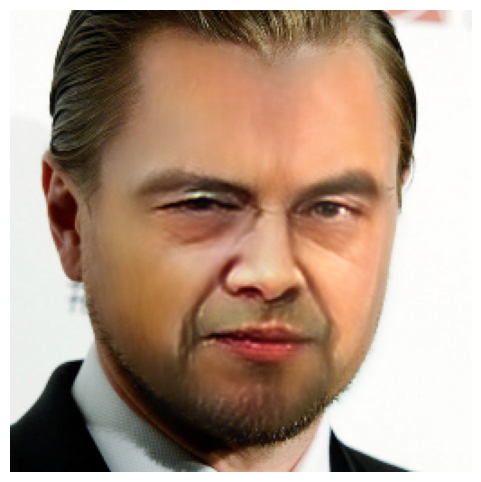

In [16]:
%matplotlib inline

# preprocessing + segmentation + inpainting + blending
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)
src = str(Path('input/a.jpg'))
tgt = str(Path('input/j.jpg'))
out_file = str(OUT_DIR / 'reenact_full_composited.png')
print('Running full pipeline:', src, '->', tgt)

result_bgr, intermediates, src_crop, tgt_crop = run_full_pipeline(src, tgt, out_path=out_file)

print('Saved full result to', out_file)

try:
    img = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(img); plt.show()
except Exception as e:
    print('Could not display image inline:', e)

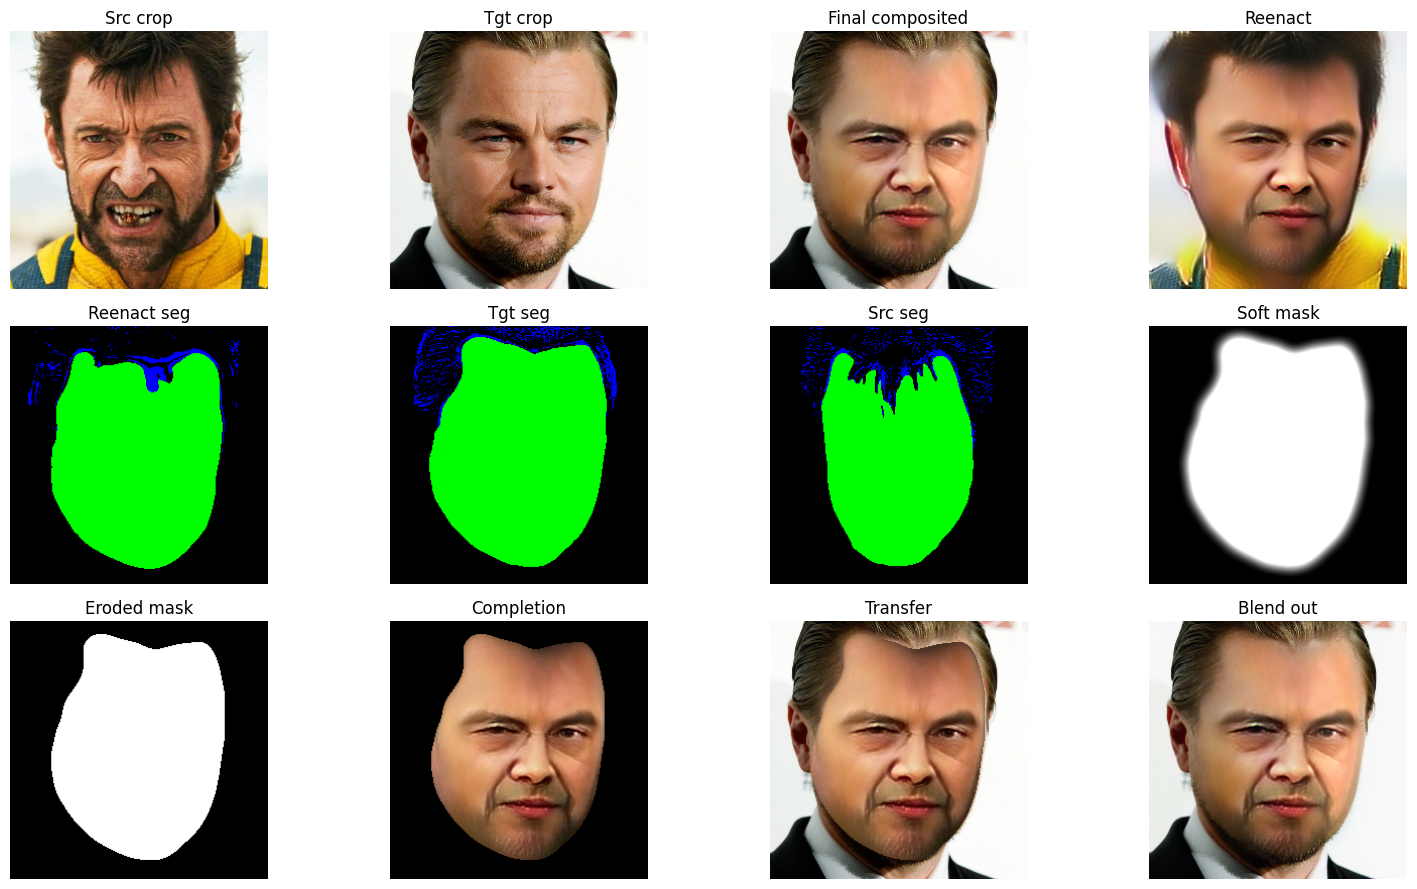

In [17]:
# Cell: Visualize intermediate steps: preprocessing, segmentation, inpainting, blending
import math
from fsgan.utils.img_utils import tensor2bgr

def tensor_to_bgr_uint8(x):
    import numpy as _np
    import torch as _torch
    if isinstance(x, _torch.Tensor):
        t = x.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        # t expected in [-1,1] or [0,1]
        if t.min() >= -1.1 and t.max() <= 1.1:
            return tensor2bgr(t).astype('uint8')
        else:
            arr = (t.numpy().transpose(1,2,0) * 255.0).clip(0,255).astype('uint8')
            return arr[:, :, ::-1]
    else:
        arr = x.copy()
        if arr.dtype != _np.uint8:
            arr = arr.astype('uint8')
        return arr

def seg_to_color(seg_arr):
    import numpy as _np
    h,w = seg_arr.shape
    cmap = _np.array([[0,0,0],[0,255,0],[0,0,255],[255,0,0],[255,255,0]], dtype='uint8')
    out = _np.zeros((h,w,3), dtype='uint8')
    labels = _np.clip(seg_arr, 0, cmap.shape[0]-1)
    for i in range(cmap.shape[0]):
        out[labels==i] = cmap[i]
    return out

# Gather images to display
imgs = []
titles = []
# Preprocessing crops
try:
    imgs.append(src_crop)
    titles.append('Src crop')
except Exception:
    pass
try:
    imgs.append(tgt_crop)
    titles.append('Tgt crop')
except Exception:
    pass
# Reenact result
try:
    imgs.append(result_bgr)
    titles.append('Final composited')
except Exception:
    pass
# Reenactment-only (generator output) if available
if 'reenact_tensor' in intermediates:
    try:
        imgs.append(tensor_to_bgr_uint8(intermediates['reenact_tensor']))
        titles.append('Reenact')
    except Exception:
        pass
# Segmentation maps
if 'reenact_seg' in intermediates:
    s = intermediates['reenact_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Reenact seg')
    except Exception:
        pass
if 'tgt_seg' in intermediates:
    s = intermediates['tgt_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Tgt seg')
    except Exception:
        pass
# Source segmentation (for original source crop) if available
if 'src_seg' in intermediates:
    s = intermediates['src_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Src seg')
    except Exception:
        pass
# Masks: soft and eroded
if 'soft_tgt_mask' in intermediates:
    m = intermediates['soft_tgt_mask']
    try:
        m_np = m.detach().cpu().numpy()[0,0]
        imgs.append((m_np*255).astype('uint8'))
        titles.append('Soft mask')
    except Exception:
        pass
if 'eroded_tgt_mask' in intermediates:
    m = intermediates['eroded_tgt_mask']
    try:
        m_np = m.detach().cpu().numpy()[0,0]
        imgs.append((m_np*255).astype('uint8'))
        titles.append('Eroded mask')
    except Exception:
        pass
# Completion / transfer / blend
for key, label in [('completion','Completion'), ('transfer','Transfer'), ('blend_out','Blend out')]:
    if key in intermediates:
        try:
            imgs.append(tensor_to_bgr_uint8(intermediates[key]))
            titles.append(label)
        except Exception:
            pass

# Plot grid
n = len(imgs)
if n == 0:
    print('No intermediates available to display')
else:
    cols = min(4, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 3*rows))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(im[:,:,::-1])
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()